In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, Distances
using Plots, UnicodePlots
using JuAFEM
using SparseArrays
const JFM = JuAFEM

JuAFEM

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 1
selected_ev            = 2;      # which Eigenvector to choose
ϵ                      = 0.2   # perturbation
t₀                      = 0.6    # parameter value corresponding to ϵ=0

0.6

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p], tolerance=1e-5)[end]

T (generic function with 1 method)

In [5]:
T_inv(x,p) = flow(rot_double_gyre, x, [t₀ + p, 0.0], tolerance=1e-9)[end]

T_inv (generic function with 1 method)

In [6]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [7]:
M = assembleMassMatrix(ctx);

In [8]:
@time A,_ = nonAdaptiveTOCollocation(ctx, y -> T_inv(y,0),project_in=true)
nothing

 15.124702 seconds (43.64 M allocations: 2.605 GiB, 5.06% gc time)


In [9]:
@time D⁰ = assembleStiffnessMatrix(ctx)
@time D¹ = A'*D⁰*A
K = 0.5(D⁰+D¹);
nothing

  0.396998 seconds (1.36 M allocations: 81.154 MiB, 8.29% gc time)
  0.107299 seconds (235.37 k allocations: 24.397 MiB)


In [10]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
u₀ = u₀[:,selected_ev]
u₀ = u₀ ./ (u₀'*M*u₀)       #L2 normalization
λ₀ = λ₀[selected_ev]

  4.529012 seconds (9.38 M allocations: 647.319 MiB, 9.59% gc time)


-50.15616399979984 + 0.0im

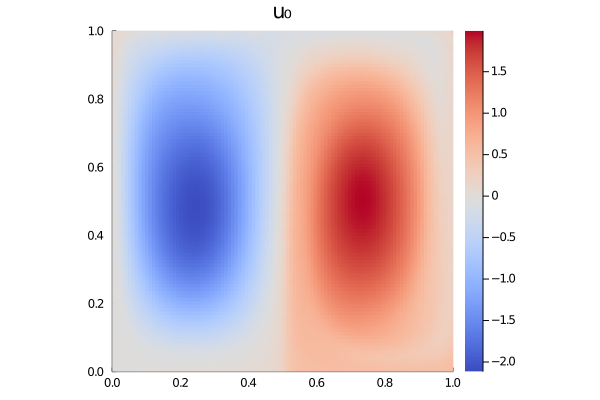

In [11]:
original = plot_u(ctx, u₀, grid_resolution, grid_resolution, colorbar=:left, color=:coolwarm, title="u₀")

In [12]:
Tdot(x) = Main.CoherentStructures.parameter_autodiff(T, x, 0)

Tdot (generic function with 1 method)

In [13]:
#Tdots_at_dofs = [Vec{2}(Main.CoherentStructures.parameter_autodiff(T, ctx.grid.nodes[j].x, 0)) for 
#        j in Main.CoherentStructures.node_to_bcdof(ctx, BoundaryData())]
W = zeros(JFM.getdim(ctx.grid),getnnodes(ctx.grid))
for i in 1:getnnodes(ctx.grid)
    W[:,i] = Tdot(ctx.grid.nodes[i].x)    
end

In [14]:
#TODO check generated code for sparsity
WA = W*A'

2×10000 Array{Float64,2}:
 0.0  -4.6977e-6  -2.06163e-11  -0.0377625  …  -8.74237e-6   -1.17048e-15
 0.0  -0.376706    0.0           2.26837        5.32527e-16   6.96731e-16

In [15]:
translation_table_old = Main.CoherentStructures.node_to_bcdof(ctx,BoundaryData())
translation_table_new = Main.CoherentStructures.bcdof_to_node(ctx,BoundaryData())

10000-element Array{Int64,1}:
     1
     2
   101
   102
     3
   103
     4
   104
     5
   105
     6
   106
     7
     ⋮
  9989
  9990
  9991
  9992
  9993
  9994
  9995
  9996
  9997
  9998
  9999
 10000

In [16]:
cv = JFM.CellScalarValues(ctx.qr, ctx.ip, ctx.ip_geom)
dh = ctx.dh
L = JFM.create_sparsity_pattern(dh)
a_L = JFM.start_assemble(L)
dofs = zeros(Int, JFM.ndofs_per_cell(dh))
n = JFM.getnbasefunctions(cv)
Le = zeros(n, n)
for cell in JFM.CellIterator(dh)
    fill!(Le, 0)
    JFM.reinit!(cv, cell)
    for q in 1:JFM.getnquadpoints(cv)
        dΩ = JFM.getdetJdV(cv, q)
        for i in 1:n
            ∇φᵢ = JFM.shape_gradient(cv, q, i)
            for j in 1:n
                ∇φⱼ = JFM.shape_gradient(cv, q, j)
                for k in 1:n
                    ∇φₖ = JFM.shape_gradient(cv, q, k)
                    Le[i,j] += (∇φᵢ ⋅ WA[:,JFM.celldofs(cell)[k]]) * (∇φₖ ⋅ ∇φⱼ) * dΩ  
                end
            end
        end
    end
    JFM.celldofs!(dofs, cell)   #hierrauf schauen
    JFM.assemble!(a_L, dofs, Le)#hierrein schauen
end
nothing

In [17]:
L = 0.5*(L+L')

10000×10000 SparseMatrixCSC{Float64,Int64} with 69202 stored entries:
  [1    ,     1]  =  -18.6472
  [2    ,     1]  =  9.32372
  [3    ,     1]  =  9.32348
  [1    ,     2]  =  9.32372
  [2    ,     2]  =  259.723
  [3    ,     2]  =  45.8841
  [4    ,     2]  =  -316.0
  [5    ,     2]  =  1.06952
  [1    ,     3]  =  9.32348
  [2    ,     3]  =  45.8841
  [3    ,     3]  =  108.546
  [4    ,     3]  =  -107.611
  ⋮
  [9898 ,  9998]  =  -15.6014
  [9899 ,  9998]  =  116.053
  [9997 ,  9998]  =  -2.85919
  [9998 ,  9998]  =  13.7293
  [9999 ,  9998]  =  -111.322
  [9899 ,  9999]  =  -223.49
  [9900 ,  9999]  =  171.576
  [9998 ,  9999]  =  -111.322
  [9999 ,  9999]  =  223.163
  [10000,  9999]  =  -59.9268
  [9900 , 10000]  =  -59.5304
  [9999 , 10000]  =  -59.9268
  [10000, 10000]  =  119.457

In [18]:
L_new = A'*L*A

10000×10000 SparseMatrixCSC{Float64,Int64} with 327585 stored entries:
  [1    ,     1]  =  -589.079
  [3    ,     1]  =  -1.23089
  [10   ,     1]  =  2.25595e-5
  [12   ,     1]  =  3.81397e-5
  [13   ,     1]  =  1.849e-5
  [14   ,     1]  =  0.000234554
  [15   ,     1]  =  2.23493e-5
  [16   ,     1]  =  0.000179327
  [17   ,     1]  =  0.000205687
  [18   ,     1]  =  0.000349507
  [20   ,     1]  =  0.000497095
  [21   ,     1]  =  0.000500244
  ⋮
  [4499 , 10000]  =  0.614387
  [4500 , 10000]  =  0.219427
  [7200 , 10000]  =  -0.133604
  [7299 , 10000]  =  -0.0284789
  [7300 , 10000]  =  -0.334438
  [9400 , 10000]  =  -2.9843
  [9499 , 10000]  =  -1.16839
  [9500 , 10000]  =  -4.86321
  [9900 , 10000]  =  6.82286e-9
  [9902 , 10000]  =  -13.1492
  [9903 , 10000]  =  -21.3576
  [9999 , 10000]  =  7.00179
  [10000, 10000]  =  200.642

In [19]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L_new*u₀ ; 0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  1.932425 seconds (4.56 M allocations: 440.699 MiB, 3.83% gc time)


-191.85838006834857 - 0.0im

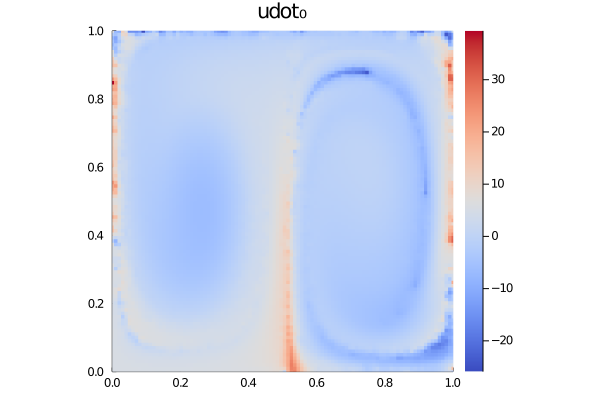

In [39]:
derivative = plot_u(ctx, max.(-10000,min.(100000,real(u_dot))), grid_resolution, grid_resolution, colorbar=:left, color=:coolwarm, title="udot₀")

In [21]:
# calculate the exact uϵ
D¹ϵ = adaptiveTOCollocationStiffnessMatrix(ctx, y -> T(y,ϵ))
Kϵ = 0.5(D⁰+D¹ϵ)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
uϵ = uϵ[:,selected_ev]
uϵ = uϵ ./ (uϵ'*M*uϵ)        #L2 normalization
λϵ = λϵ[selected_ev]

-61.45331436002857

In [22]:
λ₀ + ϵ*λ_dot

-88.52784001346956 + 0.0im

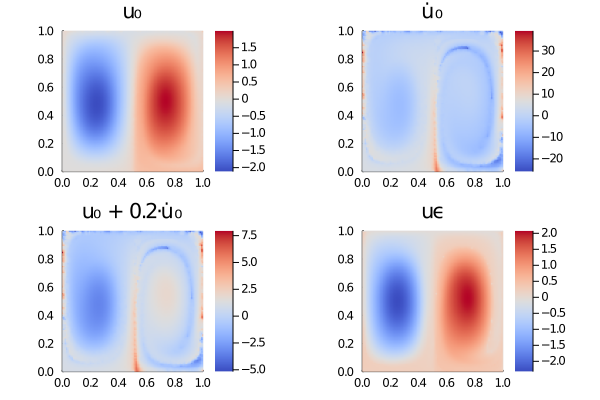

In [23]:
original      = plot_u(ctx, u₀,           grid_resolution, grid_resolution, colorbar=:left, 
    color=:coolwarm, title="u₀")
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, colorbar=:left, 
    color=:coolwarm, title="u̇ ₀")
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, colorbar=:left, 
    color=:coolwarm, title="u₀ + $(ϵ)⋅u̇ ₀")
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, colorbar=:left, 
    color=:coolwarm, title="uϵ")
Plots.plot(original,derivative,extrapolated,exact)